# Chapter 03: Regularised Linear Regression

## Introduction

This project uses data relating to rainfall and crop yields to explore the effects of different methods of regularisation. It also attempts to use hypothesis testing to detect statistically significant relationships in the context of polynomials.

## The Data

Both datasets for this project relate to India. The first contains data on agricultural production and land usage and is at State/District/Year/Crop-level [(Kaggle link)](https://www.kaggle.com/anjali21/agricultural-production-india):

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

#crop yields:
crops_raw=pd.read_csv("C:/Users/tomra/Desktop/ml_ipynb/India/crop-production-statistics-from-1997-in-india/apy.csv")

Summarising Area and Production by State/Year/Season/Crop:

In [3]:
#summing Area
crops_area=crops_raw.groupby(['State_Name', 'Crop_Year', 'Season', 'Crop']).Area.sum().to_frame(name='area').reset_index()
#summing Production
crops_prod=crops_raw.groupby(['State_Name', 'Crop_Year', 'Season', 'Crop']).Production.sum().to_frame(name='production').reset_index()
#Taking variables from Area, joining Production
crops=crops_area[['State_Name', 'Crop_Year', 'Season', 'Crop', 'area']].sort_values(by=['State_Name', 'Crop_Year', 'Season', 'Crop'],ascending=True)
crops['production']=crops_prod[['State_Name', 'Crop_Year', 'Season', 'Crop', 'production']].sort_values(by=['State_Name', 'Crop_Year', 'Season', 'Crop'], ascending=True)['production']
crops.head()

,State_Name,Crop_Year,Season,Crop,area,production
0,Andaman and Nicobar Islands,2000,Kharif,Arecanut,4354.0,7200.0
1,Andaman and Nicobar Islands,2000,Kharif,Other Kharif pulses,670.0,449.0
2,Andaman and Nicobar Islands,2000,Kharif,Rice,10881.0,32184.0
3,Andaman and Nicobar Islands,2000,Whole Year,Banana,1707.0,12714.0
4,Andaman and Nicobar Islands,2000,Whole Year,Cashewnut,800.0,219.0


We have 124 unique crops:

In [4]:
print(crops.Crop.unique().shape[0])

124


The next dataset is on rainfall, which is on state/year/month-level and goes all the way back to the beginning of the 20th century [(Kaggle link)](https://www.kaggle.com/rajanand/rainfall-in-india):

In [5]:
rainfall_raw=pd.read_csv("C:/Users/tomra/Desktop/ml_ipynb/India/rainfall-in-india/rainfall in india 1901-2015.csv")
rainfall_raw.head()

,SUBDIVISION,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,ANNUAL,Jan-Feb,Mar-May,Jun-Sep,Oct-Dec
0,ANDAMAN & NICOBAR ISLANDS,1901,49.2,87.1,29.2,2.3,528.8,517.5,365.1,481.1,332.6,388.5,558.2,33.6,3373.2,136.3,560.3,1696.3,980.3
1,ANDAMAN & NICOBAR ISLANDS,1902,0.0,159.8,12.2,0.0,446.1,537.1,228.9,753.7,666.2,197.2,359.0,160.5,3520.7,159.8,458.3,2185.9,716.7
2,ANDAMAN & NICOBAR ISLANDS,1903,12.7,144.0,0.0,1.0,235.1,479.9,728.4,326.7,339.0,181.2,284.4,225.0,2957.4,156.7,236.1,1874.0,690.6
3,ANDAMAN & NICOBAR ISLANDS,1904,9.4,14.7,0.0,202.4,304.5,495.1,502.0,160.1,820.4,222.2,308.7,40.1,3079.6,24.1,506.9,1977.6,571.0
4,ANDAMAN & NICOBAR ISLANDS,1905,1.3,0.0,3.3,26.9,279.5,628.7,368.7,330.5,297.0,260.7,25.4,344.7,2566.7,1.3,309.7,1624.9,630.8


In [6]:
rain=rainfall_raw.drop(columns=["Jan-Feb", "Mar-May", "Jun-Sep", "Oct-Dec"])
rain.head()

,SUBDIVISION,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,ANNUAL
0,ANDAMAN & NICOBAR ISLANDS,1901,49.2,87.1,29.2,2.3,528.8,517.5,365.1,481.1,332.6,388.5,558.2,33.6,3373.2
1,ANDAMAN & NICOBAR ISLANDS,1902,0.0,159.8,12.2,0.0,446.1,537.1,228.9,753.7,666.2,197.2,359.0,160.5,3520.7
2,ANDAMAN & NICOBAR ISLANDS,1903,12.7,144.0,0.0,1.0,235.1,479.9,728.4,326.7,339.0,181.2,284.4,225.0,2957.4
3,ANDAMAN & NICOBAR ISLANDS,1904,9.4,14.7,0.0,202.4,304.5,495.1,502.0,160.1,820.4,222.2,308.7,40.1,3079.6
4,ANDAMAN & NICOBAR ISLANDS,1905,1.3,0.0,3.3,26.9,279.5,628.7,368.7,330.5,297.0,260.7,25.4,344.7,2566.7


Since the crops data is at seasonal level, we need to summarise the rainfall data at seasonal level. Growing seasons in India are quite idiosyncratic: "Kharif" is the monsoon season and "Rabi" roughly corresponds to winter/spring. These seasons as well as those we are more familiar with are used in the data; some crops also appear to be grown throughout the year:

In [7]:
rain["Kharif_R"]=rain[["JUL", "AUG", "SEP" , "OCT"]].sum(axis=1)
rain["Rabi_R"]=rain[["NOV", "DEC", "JAN" , "FEB", "MAR"]].sum(axis=1)
rain["Summer_R"]=rain[["APR", "MAY", "JUN"]].sum(axis=1)
rain["Autumn_R"]=rain[["SEP", "OCT", "NOV"]].sum(axis=1)
rain["Winter_R"]=rain[["DEC", "JAN", "FEB"]].sum(axis=1)
rain["Annual_R"]=rain[["ANNUAL"]]
rain=rain[["YEAR", "SUBDIVISION", "Kharif_R", "Rabi_R", "Summer_R", "Winter_R", "Autumn_R", "Annual_R"]]
rain.head()

,YEAR,SUBDIVISION,Kharif_R,Rabi_R,Summer_R,Winter_R,Autumn_R,Annual_R
0,1901,ANDAMAN & NICOBAR ISLANDS,1567.3,757.3,1048.6,169.9,1279.3,3373.2
1,1902,ANDAMAN & NICOBAR ISLANDS,1846.0,691.5,983.2,320.3,1222.4,3520.7
2,1903,ANDAMAN & NICOBAR ISLANDS,1575.3,666.1,716.0,381.7,804.6,2957.4
3,1904,ANDAMAN & NICOBAR ISLANDS,1704.7,372.9,1002.0,64.2,1351.3,3079.6
4,1905,ANDAMAN & NICOBAR ISLANDS,1256.9,374.7,935.1,346.0,583.1,2566.7


We are going to need tgo join the datasets by state/subdivision, but the names used do not correspond:

In [9]:
print(np.sort(crops.State_Name.unique()))
print(np.sort(rain.SUBDIVISION.unique()))

['Andaman and Nicobar Islands' 'Andhra Pradesh' 'Arunachal Pradesh'
 'Assam' 'Bihar' 'Chandigarh' 'Chhattisgarh' 'Dadra and Nagar Haveli'
 'Goa' 'Gujarat' 'Haryana' 'Himachal Pradesh' 'Jammu and Kashmir '
 'Jharkhand' 'Karnataka' 'Kerala' 'Madhya Pradesh' 'Maharashtra' 'Manipur'
 'Meghalaya' 'Mizoram' 'Nagaland' 'Odisha' 'Puducherry' 'Punjab'
 'Rajasthan' 'Sikkim' 'Tamil Nadu' 'Telangana ' 'Tripura' 'Uttar Pradesh'
 'Uttarakhand' 'West Bengal']
['ANDAMAN & NICOBAR ISLANDS' 'ARUNACHAL PRADESH' 'ASSAM & MEGHALAYA'
 'BIHAR' 'CHHATTISGARH' 'COASTAL ANDHRA PRADESH' 'COASTAL KARNATAKA'
 'EAST MADHYA PRADESH' 'EAST RAJASTHAN' 'EAST UTTAR PRADESH'
 'GANGETIC WEST BENGAL' 'GUJARAT REGION' 'HARYANA DELHI & CHANDIGARH'
 'HIMACHAL PRADESH' 'JAMMU & KASHMIR' 'JHARKHAND' 'KERALA' 'KONKAN & GOA'
 'LAKSHADWEEP' 'MADHYA MAHARASHTRA' 'MATATHWADA' 'NAGA MANI MIZO TRIPURA'
 'NORTH INTERIOR KARNATAKA' 'ORISSA' 'PUNJAB' 'RAYALSEEMA'
 'SAURASHTRA & KUTCH' 'SOUTH INTERIOR KARNATAKA'
 'SUB HIMALAYAN WEST BENGA

To match the names,we will set up an array whereby the states in the crops dataset represent rows and the rainfall dataset columns, containing a metric indicating the nearness of the match. Since the rainfall dataset contains more unique states, we will then create a vector of rainfall states which represent the nearest match to each crop state:

In [11]:
import numpy as np
from difflib import SequenceMatcher

match_array=np.empty((crop_states.shape[0], rain_states.shape[0]))

for i in range(crop_states.shape[0]):
    for j in range(rain_states.shape[0]):
        
        match_array[i,j]=SequenceMatcher(None, crop_states[i].upper(), rain_states[j].upper()).ratio()       


merge_array=np.array([[crop_states], [rain_states[np.argmax(match_array, axis=1)]]]).squeeze().T

merge_frame=pd.DataFrame(merge_array,  columns=['crop_state', 'rain_state'])

print(merge_frame)

                     crop_state                          rain_state
0   Andaman and Nicobar Islands           ANDAMAN & NICOBAR ISLANDS
1                Andhra Pradesh              COASTAL ANDHRA PRADESH
2             Arunachal Pradesh                   ARUNACHAL PRADESH
3                         Assam                              ORISSA
4                         Bihar                               BIHAR
5                    Chandigarh                        CHHATTISGARH
6                  Chhattisgarh                        CHHATTISGARH
7        Dadra and Nagar Haveli          HARYANA DELHI & CHANDIGARH
8                           Goa                              ORISSA
9                       Gujarat                      GUJARAT REGION
10                      Haryana                           JHARKHAND
11             Himachal Pradesh                    HIMACHAL PRADESH
12           Jammu and Kashmir                      JAMMU & KASHMIR
13                    Jharkhand                 

Not bad, but far from perfect. I can't really improve this manually without a detailed knowledge of Indian geography, so I'm just going to strip out the rows where the names don't appear to correspond:

In [14]:
bad_matches=['Assam', 'Chandigarh', 'Dadra and Nagar Haveli', 'Goa', 'Haryana', 'Manipur', 'Mizoram',
             'Nagaland', 'Odisha', 'Puducherry']
 
merge_frame=merge_frame[~merge_frame.crop_state.isin(bad_matches)]

rain_states=rain.merge(merge_frame, left_on='SUBDIVISION', right_on='rain_state', how='inner').drop(columns=["rain_state"])
rain_states.head()

data=crops.merge(rain_states, left_on=('Crop_Year', 'State_Name'), right_on=('YEAR', 'crop_state'), how='inner').drop(columns=["SUBDIVISION", "YEAR", "crop_state"])
data.head()

,State_Name,Crop_Year,Season,Crop,area,production,Kharif_R,Rabi_R,Summer_R,Winter_R,Autumn_R,Annual_R
0,Andaman and Nicobar Islands,2000,Kharif,Arecanut,4354.0,7200.0,1208.4,556.8,997.9,227.2,729.6,2763.2
1,Andaman and Nicobar Islands,2000,Kharif,Other Kharif pulses,670.0,449.0,1208.4,556.8,997.9,227.2,729.6,2763.2
2,Andaman and Nicobar Islands,2000,Kharif,Rice,10881.0,32184.0,1208.4,556.8,997.9,227.2,729.6,2763.2
3,Andaman and Nicobar Islands,2000,Whole Year,Banana,1707.0,12714.0,1208.4,556.8,997.9,227.2,729.6,2763.2
4,Andaman and Nicobar Islands,2000,Whole Year,Cashewnut,800.0,219.0,1208.4,556.8,997.9,227.2,729.6,2763.2


We now need to get the rainfall for each crop to correspond to it's season:

In [15]:
data=data.rename(columns={'Annual_R': 'Whole Year_R'})

for season in data.Season.unique():
    data.loc[data.Season==season, 'Rain']=data[season.strip()+'_R']

data["Yield"]=data["production"]/data["area"]
data.head()

,State_Name,Crop_Year,Season,Crop,area,production,Kharif_R,Rabi_R,Summer_R,Winter_R,Autumn_R,Whole Year_R,Rain,Yield
0,Andaman and Nicobar Islands,2000,Kharif,Arecanut,4354.0,7200.0,1208.4,556.8,997.9,227.2,729.6,2763.2,1208.4,1.653652
1,Andaman and Nicobar Islands,2000,Kharif,Other Kharif pulses,670.0,449.0,1208.4,556.8,997.9,227.2,729.6,2763.2,1208.4,0.670149
2,Andaman and Nicobar Islands,2000,Kharif,Rice,10881.0,32184.0,1208.4,556.8,997.9,227.2,729.6,2763.2,1208.4,2.957816
3,Andaman and Nicobar Islands,2000,Whole Year,Banana,1707.0,12714.0,1208.4,556.8,997.9,227.2,729.6,2763.2,2763.2,7.448155
4,Andaman and Nicobar Islands,2000,Whole Year,Cashewnut,800.0,219.0,1208.4,556.8,997.9,227.2,729.6,2763.2,2763.2,0.273750


Since "Area" is likely to vary over time at a regional level due to land use changes, and this in turn is likely to influence production,  we have created a new variable called "Yield", which is the ratio of production to area, in order to disaggregate this effect. This will be our target variable. 

## Pre-Analysis

Since each crop is likely to map rainfall to Yield in it's own biologically-determined way, we will attempt to analyse Yield in terms of rainfall for each crop individually. 

We might as well filter out crops without a large number of rows:

In [20]:
data=data[["Crop", "Rain", "Yield"]]
Crops=data.groupby("Crop").size().to_frame(name='n').reset_index()
Crops=np.array(Crops[Crops.n>100]["Crop"])
data=data[data.Crop.isin(Crops)]

Looking at Yield by Crop, it is encouraging that most crops appear at least pseudo-normal, which is useful as this assumption underpins regressional analysis and hypothesis testing. A few appear to have anomalous-looking outliers:

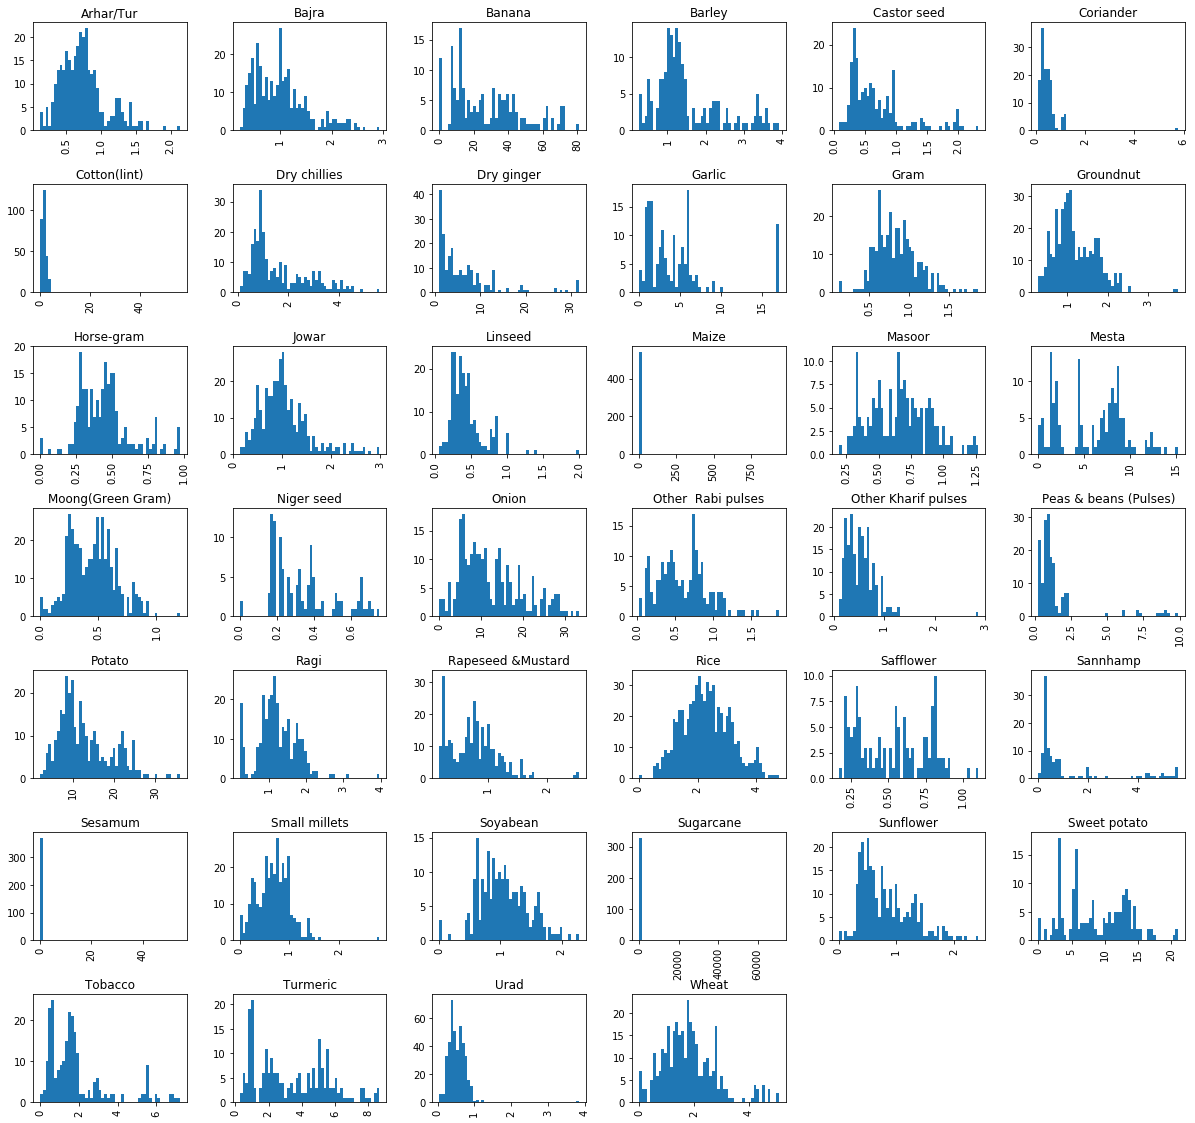

In [22]:
data.Yield.hist(bins=50, by=data.Crop, figsize=(20,20))
plt.show()

Taking scatterplots of Yield against Rainfall:

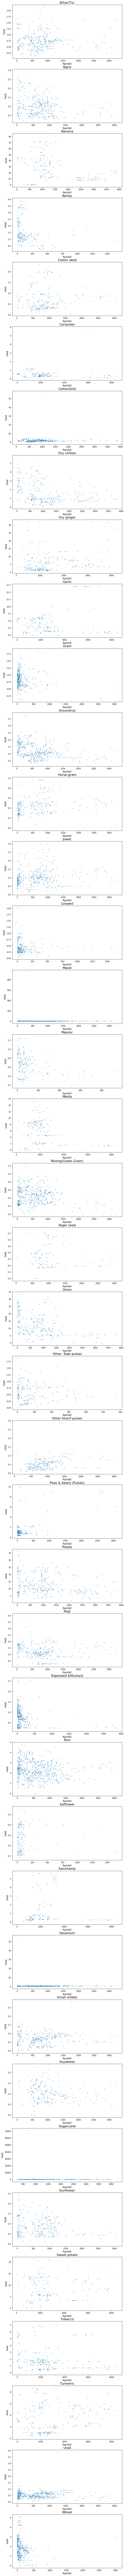

In [34]:
fig, ax = plt.subplots(Crops.shape[0], figsize=(10,Crops.shape[0]*6))

for i in range(Crops.shape[0]):
    
    tmp=data[data.Crop==Crops[i]]
    ax[i].scatter(tmp.Rain, tmp.Yield , s=3)
    ax[i].set_title(Crops[i], fontsize=16)
    ax[i].set_xlabel("Rainfall", fontsize=12)
    ax[i].set_ylabel("Yield", fontsize=12)

It appears that a few of the crops show some correlation with rainfall, while others show no particular relationship. The above also confirms that for some crops there are outliers which appear anomalous, so we will remove these:

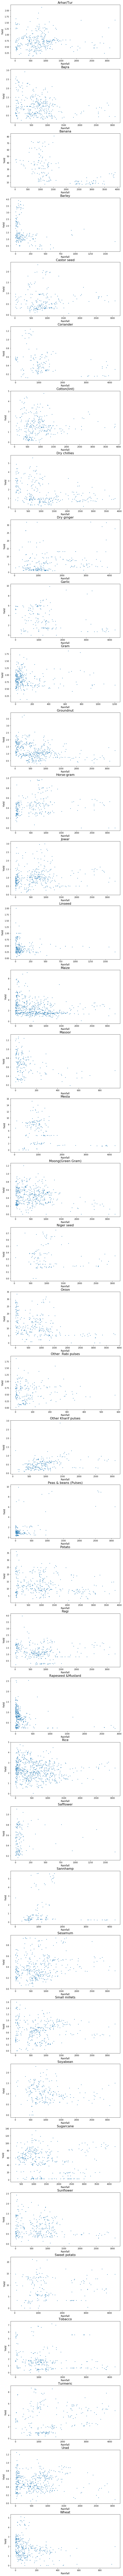

In [37]:
data=data[~((data.Crop.str.strip()=="Banana")&(data.Yield<2))]
data=data[~((data.Crop.str.strip()=="Coriander")&(data.Yield>5))]
data=data[~((data.Crop.str.strip()=="Cotton(lint)")&(data.Yield>50))]
data=data[~((data.Crop.str.strip()=="Garlic")&(data.Yield>15))]
data=data[~((data.Crop.str.strip()=="Maize")&(data.Yield>800))]
data=data[~((data.Crop.str.strip()=="Other Kharif pulses")&(data.Yield>3))]
data=data[~((data.Crop.str.strip()=="Sesamum")&(data.Yield>50))]
data=data[~((data.Crop.str.strip()=="Small millets")&(data.Yield>2.5))]
data=data[~((data.Crop.str.strip()=="Sugarcane")&(data.Yield>1000))]
data=data[~((data.Crop.str.strip()=="Urad")&(data.Yield>3.5))]
data=data[~((data.Crop.str.strip()=="Wheat")&(data.Rain>1000))]
data=data[~((data.Crop.str.strip()=="Gram")&(data.Rain>2500))]

fig, ax = plt.subplots(Crops.shape[0], figsize=(10,Crops.shape[0]*6))

for i in range(Crops.shape[0]):
    
    tmp=data[data.Crop==Crops[i]]
    ax[i].scatter(tmp.Rain, tmp.Yield , s=3)
    ax[i].set_title(Crops[i], fontsize=16)
    ax[i].set_xlabel("Rainfall", fontsize=12)
    ax[i].set_ylabel("Yield", fontsize=12)

## Finding Correlations

Where relationships between Yield and Rainfall exist, they generally appear non-linear, such that rainfall reduces yield (an interesting result, but then again we are talking about a great deal of rain) and then appears to level off. Therefore polynomially expanding the data seems like a sensible move. Fitting a model to polynomial data consists of fitting a weight to each polynomial, in the same way that fitting a multilinear model fits weights to each input variable. Therefore a p-value can be generated from an F distribution as in the multilinear case and we can thereby test whether a statistically significant relationship exists. 

Sklearn doesn't seem to be well set up for this but it's quite easy to implement in the statsmodel libary. The below function  will look for statistically significant relationships for a degree 2 polynomial at the 5% level by group:

In [38]:
import statsmodels.formula.api as smf

def significant_classes(data, Classes, Xvar, yvar, cvar, deg, sig_level):    
     
    out_classes=[]
    pvals=[]
    
    for i in range(Classes.shape[0]):         
            
        tmp = data[data[cvar]==Classes[i]][[Xvar, yvar]].reset_index()
        tmp = tmp.replace(-np.inf, np.nan).dropna()

        X = np.array(tmp[Xvar]).reshape(-1,1).squeeze()      
        y = np.array(tmp[yvar])
        
        df = pd.DataFrame(columns=['y', 'x'])
        df['x'] = X
        df['y'] = y

        weights = np.polyfit(X, y, deg)
        model = np.poly1d(weights)
        results = smf.ols(formula='y ~ model(x)', data=df).fit()
        
        if results.pvalues[1]<sig_level:
            out_classes.append(Classes[i])
            pvals.append(results.pvalues[1])
    
    return out_classes, pvals

Looking at which crops have been returned:

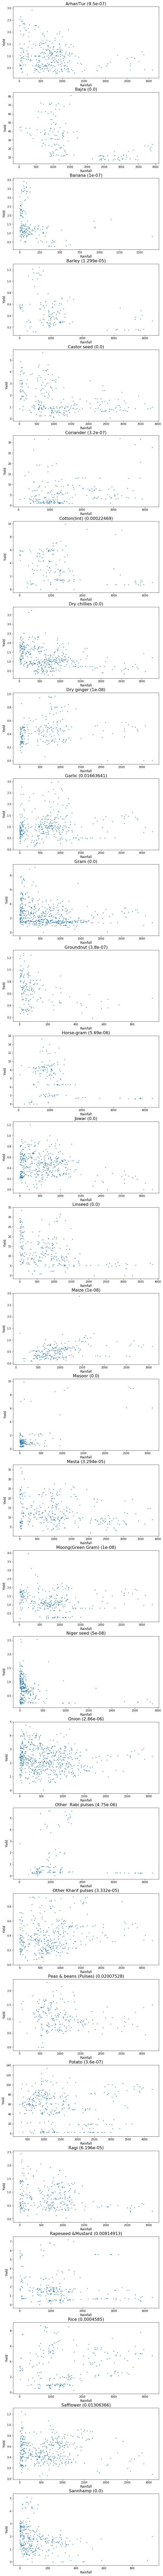

In [44]:
sig_crops, pvals=significant_classes(data, Crops, "Rain", "Yield", "Crop", deg=2, sig_level=0.05)
fig, ax = plt.subplots(len(sig_crops), figsize=(10,len(sig_crops)*6))

for i in range(len(sig_crops)):
    
    tmp=data[data.Crop==sig_crops[i]]
    ax[i].scatter(tmp.Rain, tmp.Yield , s=3)
    ax[i].set_title(Crops[i] + " (" +str(round(pvals[i], 8)) + ")" , fontsize=16)
    ax[i].set_xlabel("Rainfall", fontsize=12)
    ax[i].set_ylabel("Yield", fontsize=12)

These all appear to have some sort of relationship, so the approach seems to have been successful. For the sake of brevity later on, we will just take the 6 most significant relationships:

In [46]:
sig_df=pd.DataFrame(columns=['crop', 'pvalue'])
sig_df['crop']=sig_crops
sig_df['pvalue']=pvals
sig_df=sig_df.sort_values(by='pvalue', ascending=True)
sig_crops2=np.array(sig_df['crop'])[1:7]
print(sig_crops2)

['Maize' 'Groundnut' 'Banana' 'Dry chillies' 'Onion' 'Moong(Green Gram)']


## Fitting Regularised Models

The below function will optimise, fit and display a given set of models by class:

In [55]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso, ElasticNet, Ridge, LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error

def fit_models_by_class(data, Classes, Xvar, yvar, cvar, model_classes, styles, df):
    
    fig, ax = plt.subplots(Classes.shape[0], figsize=(15,Classes.shape[0]*8))
   
    for i in range(Classes.shape[0]):        
        
        tmp = data[data[cvar]==Classes[i]][[Xvar, yvar]].reset_index()
        tmp = tmp.replace(-np.inf, np.nan).dropna()
        
        X = np.array(tmp[Xvar]).reshape(-1,1)
        X_new = np.linspace(0, max(X)*1.5,100).reshape(100, 1)
        y = np.array(tmp[yvar])
        
        param_grid = [{'regul_reg__alpha': [10*10**-x for x in range(1,10)]}]
        styles = ("b-", "g--", "r:")
        
        for model_class, style in zip(model_classes, styles):
            model = model_class() 
            model_name= model.__class__.__name__
            model = Pipeline([
                    ("poly_features", PolynomialFeatures(degree=df, include_bias=False)),                    
                    ("std_scaler", StandardScaler()),
                    ("imputer1", SimpleImputer(missing_values=np.nan, strategy='median')),                             
                    ("regul_reg", model),
                ])          
            
              
            
            grid_search=GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
            grid_search.fit(X, y)
            score=grid_search.best_score_
            param=grid_search.best_params_.get("regul_reg__alpha")
            y_new_regul = grid_search.predict(X_new) 
            
         
            ax[i].plot(X_new, y_new_regul, style, linewidth=2, 
                label= model_name + " (MSE = " + str(-score)[:6] + ", " + r"$\alpha = {}$".format(param) + ")")
                
                
        polynomial_regression= Pipeline([
                    ("poly_features", PolynomialFeatures(degree=df, include_bias=False)),                    
                    ("std_scaler", StandardScaler()),
                    ("imputer1", SimpleImputer(missing_values=np.nan, strategy='median')),                             
                    ("lin_reg", LinearRegression()),
                ])
        
        polynomial_regression.fit(X,y)
        y_new_poly = polynomial_regression.predict(X_new)  
        y_poly = polynomial_regression.predict(X)
        poly_score=mean_squared_error(y_poly, y)
        
        ax[i].plot(X_new, y_new_poly, 'y-.', label="Linear Regression (MSE = " + str(round(poly_score,4))+ ")")                                   
        ax[i].plot(X, y, "b.", linewidth=3)
        ax[i].legend(loc="upper right", fontsize=12)
        ax[i].set_xlabel(Xvar, fontsize=12)
        ax[i].set_ylabel(yvar, fontsize=12)
        ax[i].set_xlim(0, 1.5*max(X))
        ax[i].set_ylim(0,1.1*max(y))           
        ax[i].set_title(Classes[i], fontsize=16)  

The goal of regularisation models is to mitigate overfitting in multilinear or polynomial data. This means potentially increasing training error in order to reduce generalisation error. 

We will try the following models:

- LinearRegression: does nothing to mitigate overfitting
- Ridge: includes a regularisation term in the loss function which is half the sum of squares of the parameters - minimising the   loss function therefore entails minimising the parameters, thereby flattening the curve
- Lasso: regularisation term is the sum of the absolute value of the parameters - this approach can set some parameters to zero,   thereby exercising feature selection
- ElasticNet: regularisation term includes both Ridge and Lasso terms, with a weighting factor between them - result is a    mixture of the two approaches


Trying this with polynomial degree 2:

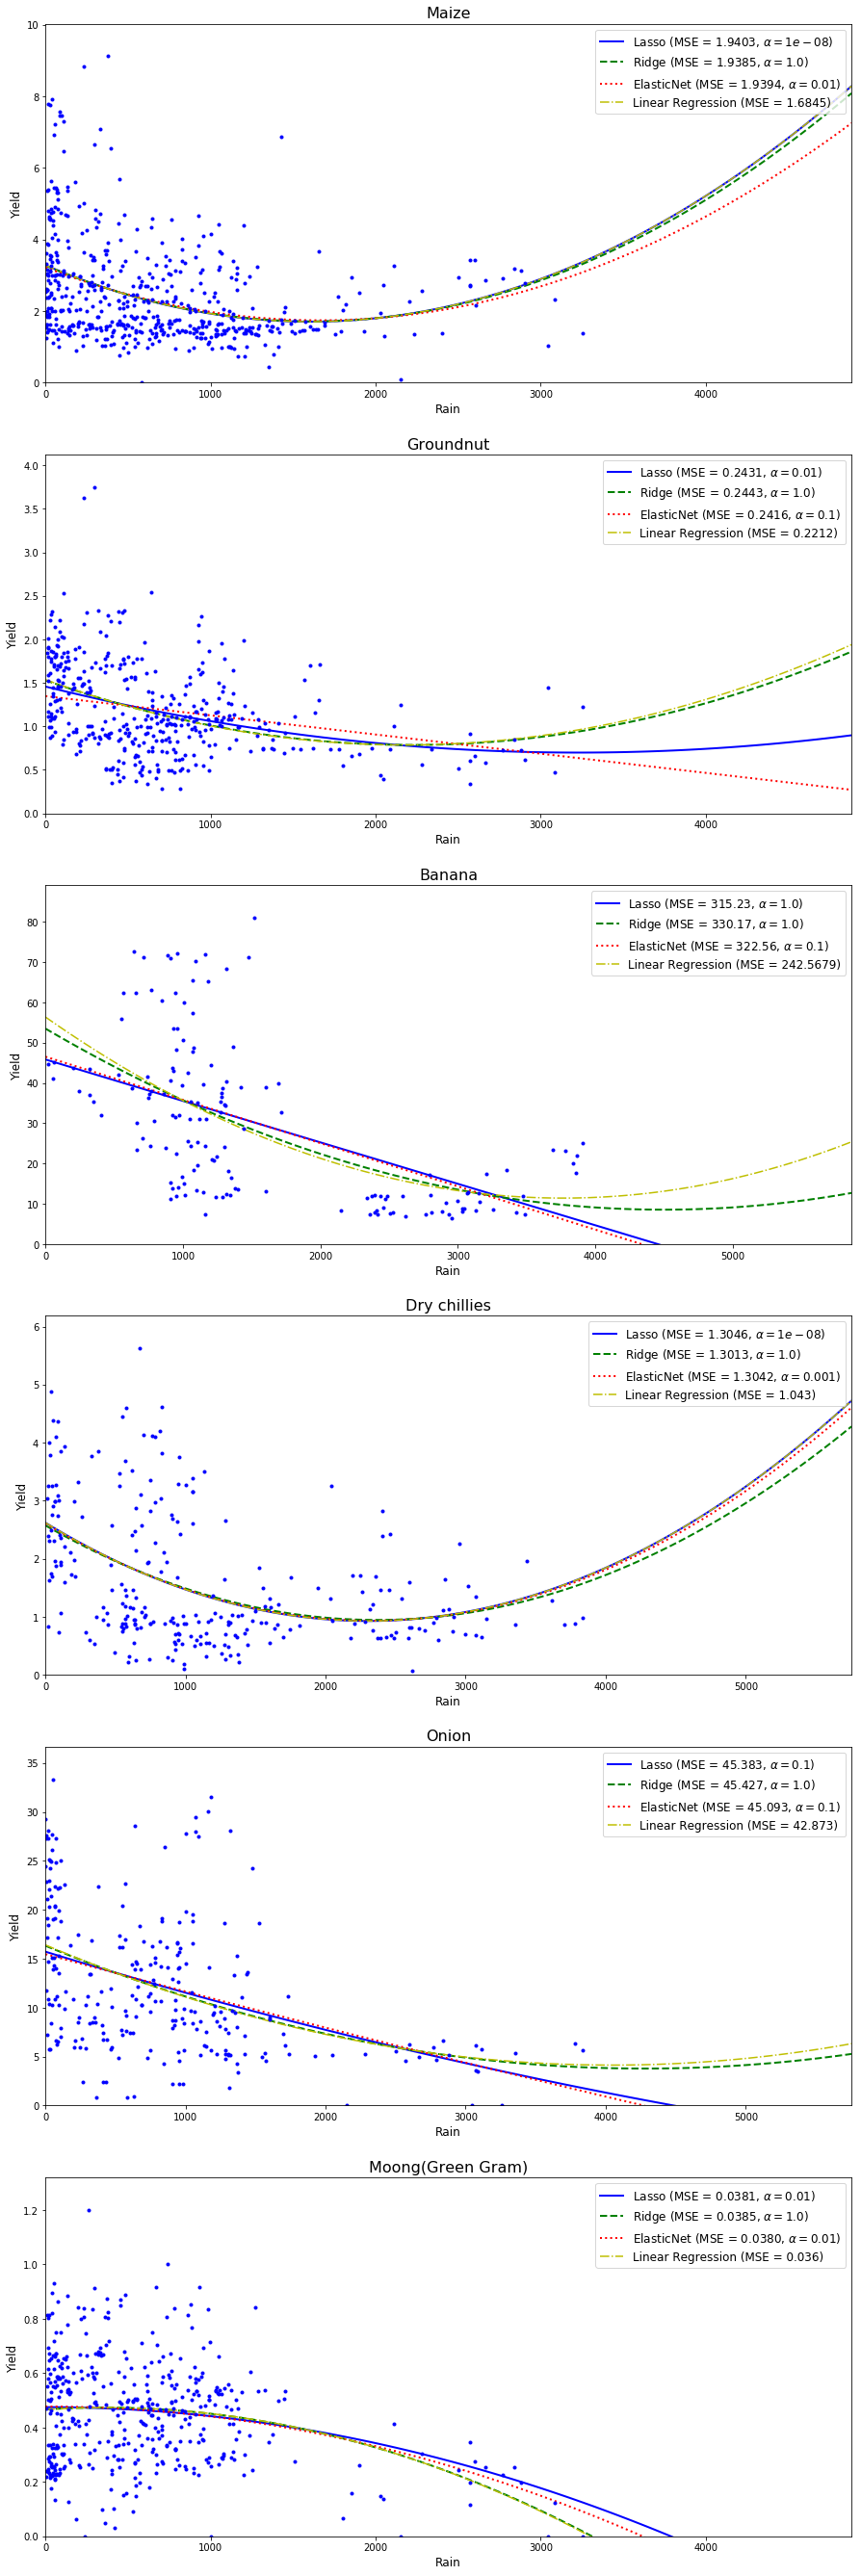

In [56]:
import warnings
warnings.filterwarnings(action='ignore')

fit_models_by_class(data,  Classes=sig_crops2, Xvar="Rain", yvar="Yield",cvar="Crop", model_classes=(Lasso, Ridge, ElasticNet), styles=("b-", "g--", "r:"), df=2)

Some notes:

- Linear Regression consistently achieves the lowest error, since this approach does nothing to mitigate overfitting
- ElasticNet and Lasso both sometimes fit linear or near-linear curves. In these cases, Lasso has parameterised the second-degree polynomial as zero, and ElasticNet as weighted it near zero with some value taken from the Ridge term
- The alpha terms in the legend represent the weights applied to the respective regularisation terms. GridSearchCV is fitting these to be optimal in terms of training error, but they are ending up quite high - the data seems to be such that additional "wobbling" does not significantly reduce training error

Trying a higher-order polynomial (30):

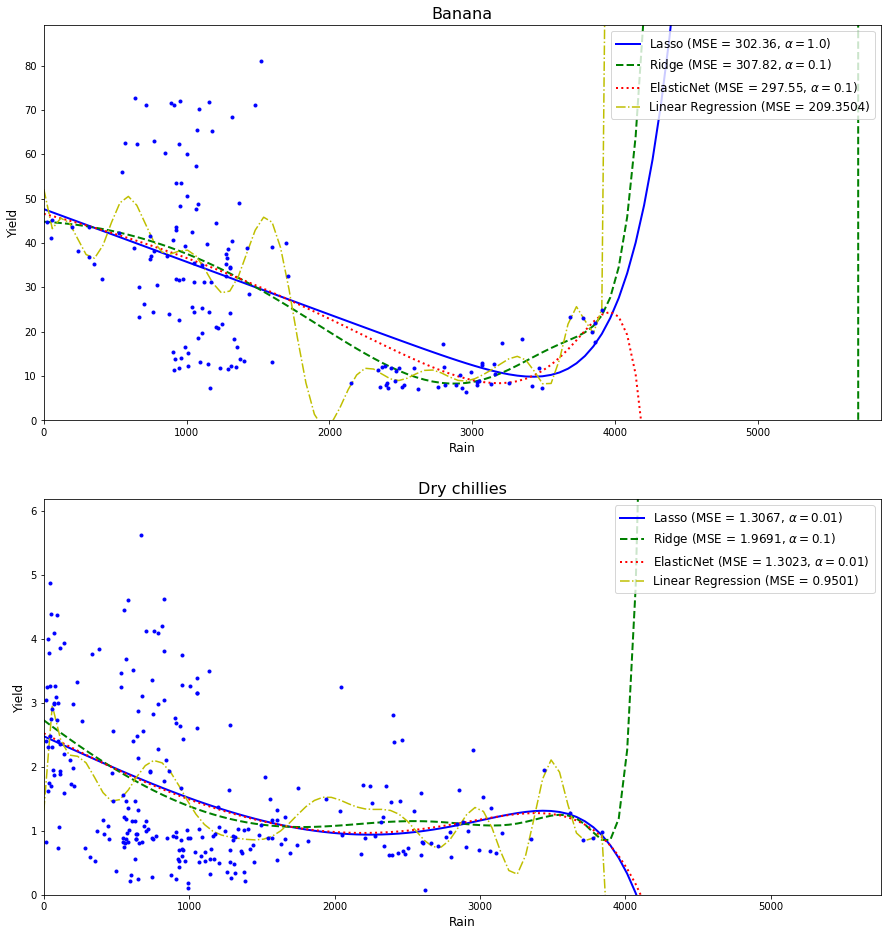

In [65]:
fit_models_by_class(data,  Classes=sig_crops2, Xvar="Rain", yvar="Yield",cvar="Crop", model_classes=(Lasso, Ridge, ElasticNet), styles=("b-", "g--", "r:"), df=30)

Some notes:

- The models appear quite similar, in terms of both training error and predictions - Linear Regression is the obvious exception
- Training errors are generally lower, but not by much - only Linear Regression seems a big improvement: the data doesn't seem to justify such a high level polynomial; where curvature exists, there doesn't not appear to be any local critical points


I lastly want to examine how the models perform in terms of generalisation error. In particular, I would like to see how training/generalisation errors change as the model becomes more complex (higher order polynomials). 

The below plots the training/generalisation error for each model across polynomials:

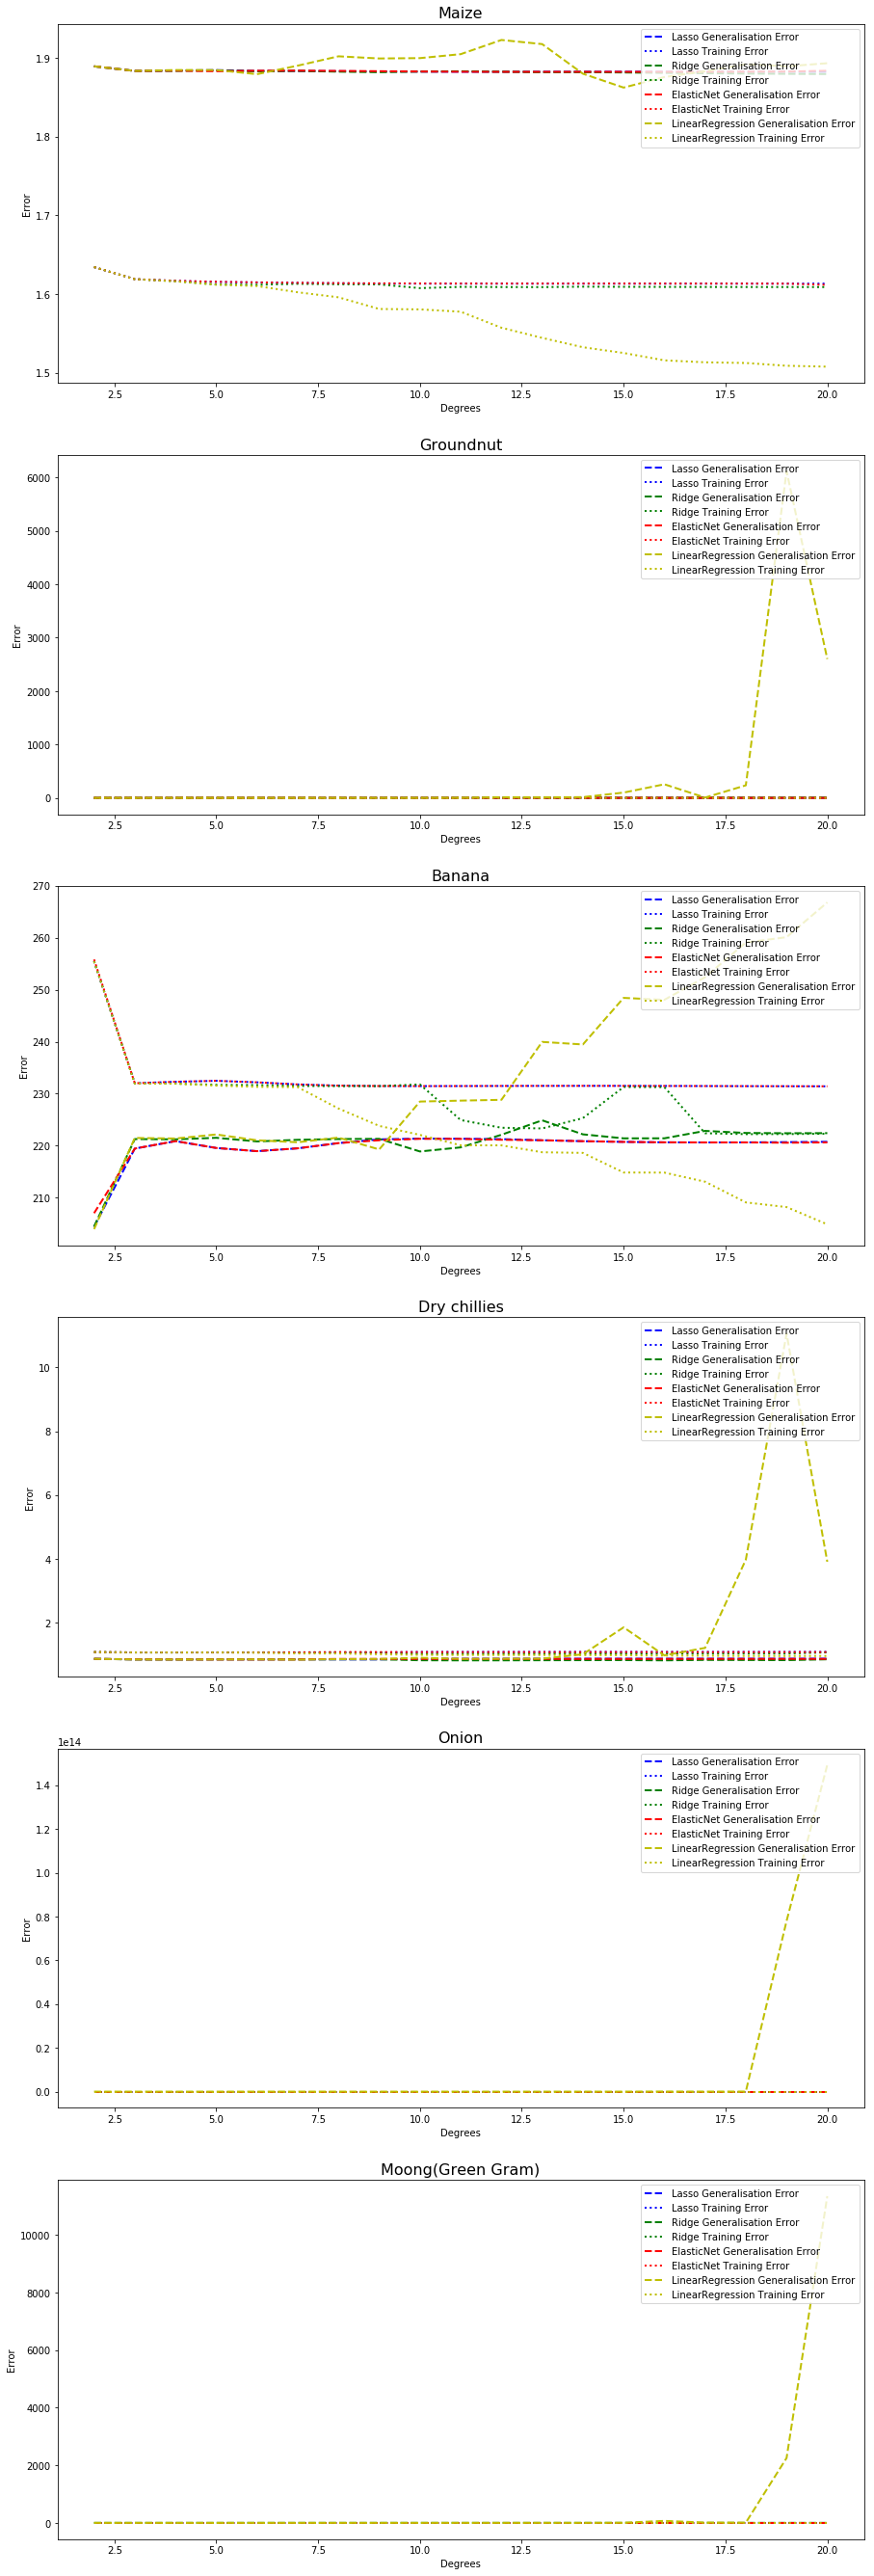

In [62]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def error_comparison(data,  Classes, Xvar, yvar, cvar, model_classes=(Lasso, Ridge, ElasticNet)):
    
    fig, ax = plt.subplots(Classes.shape[0], figsize=(15,Classes.shape[0]*8))
     
    for i in range(Classes.shape[0]):

        
        tmp = data[data[cvar]==Classes[i]][[Xvar, yvar]].reset_index()
        tmp = tmp.replace(-np.inf, np.nan).dropna()

        X = np.array(tmp[Xvar]).reshape(-1,1)        
        y = np.array(tmp[yvar])
        
        X_train, X_val, y_train, y_val=train_test_split(X, y, test_size=0.2)
        
        gen_styles = ("b--", "g--", "r--", "y--")
        train_styles = ("b:", "g:", "r:", "y:")
              
        for model_class, train_style, gen_style in zip(model_classes, train_styles, gen_styles):        
          
            degs=[]
            gerr=[]
            terr=[]
        
            for deg in range(2,21):             
                model = model_class() 
                model_name= model.__class__.__name__
                
                
                model = Pipeline([
                    ("poly_features", PolynomialFeatures(degree=deg, include_bias=False)),                    
                    ("std_scaler", StandardScaler()),
                    ("imputer1", SimpleImputer(missing_values=np.nan, strategy='median')),                             
                    ("regul_reg", model),
                  
                ])
                
                if model_name == "LinearRegression":
                    
                    model.fit(X_train,y_train)
                    yval_predict = model.predict(X_val)
                    ytrain_predict = model.predict(X_train)
                    
                else:
                    
                    param_grid = [{'regul_reg__alpha': [10*10**-x for x in range(1,10)]}]
                    grid_search=GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
                    grid_search.fit(X_train, y_train)
               
                    yval_predict = grid_search.predict(X_val)
                    ytrain_predict = grid_search.predict(X_train)
                
                
                generalised_error=mean_squared_error(yval_predict, y_val)
                train_error=mean_squared_error(ytrain_predict, y_train)

                degs.append(deg)
                gerr.append(generalised_error)
                terr.append(train_error)
                
            ax[i].plot(degs, gerr,  gen_style, linewidth=2, label= model_name + " Generalisation Error")
            ax[i].plot(degs, terr, train_style, linewidth=2, label= model_name + " Training Error")
            ax[i].legend(loc="upper right", fontsize=10)
            ax[i].set_title(Classes[i], fontsize=16)
            ax[i].set_xlabel("Degrees")
            ax[i].set_ylabel("Error")

error_comparison(data,  Classes=sig_crops2, Xvar="Rain", yvar="Yield",cvar="Crop", model_classes=(Lasso, Ridge, ElasticNet, LinearRegression))
              
    

Notes:

- Generalisation  error is generally higher than  training error, as expected - the fact that it is often quite a lot higher shows that we are generally overfitting
- The models perform similarly, except that Linear Regression sometimes manages to reduce training error at the expense of generalisation error
- The regularised models often just flatten out - the additional polynomials do not reduce error enough to justify non-negligible parameters
